# LDA Topic Modeling on Drug Review Dataset (Drugs.com)

Niccolò Rocchi, nik9991u@gmail.com

## Data import

In [124]:
# Import libraries
import pandas as pd
import csv, html, re, itertools, scipy
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# %matplotlib inline
import seaborn as sns
from sklearn.manifold import TSNE
# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.layouts import column
from bokeh.palettes import all_palettes
output_notebook()

from matplotlib.lines import Line2D
import seaborn as sns

from gensim.models import LdaModel
from gensim import corpora
from sklearn.manifold import TSNE
# !pip install ipympl
#%matplotlib widget
# %matplotlib notebook # if in Jupyter for rotating and zooming

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Load data
data = pd.read_csv("drive/MyDrive/data_train_class_balanced_9-4.csv").drop('Unnamed: 0', axis = 1)
data['review'] = data['review'].apply(html.unescape)

## Preprocessing

In [ ]:
# Import Text Mining libraries
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from textblob import TextBlob
import gensim
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
# Define useful classes
%%capture
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
def correct (text):
  textBlb = TextBlob(text)        
  textCorrected = textBlb.correct()
  return textCorrected

In [ ]:
def preprocessing(text):

  # Tokenization
  tokens = word_tokenize(text.lower())

  # Keep only alphabet strings
  tokens = [t for t in tokens if t.isalpha()]

  # Correct text
  # tokens = [correct(t) for t in tokens]

  # Stop words removal
  tokens = [t for t in tokens if t not in stop_words]

  # Lemmatization
  # tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens]

  # Stemming (Porter stemmer)
  tokens = [porter_stemmer.stem(t) for t in tokens]

  # Short words removal
  # tokens = [t for t in tokens if len(t) > 2]

  return tokens

In [ ]:
# Preprocess data
reviews = data['review'].apply(preprocessing)

In [ ]:
# Create dictionary
dictionary = gensim.corpora.Dictionary(reviews)

# Filter words that occurs in less than 'less'% documents and words that occurs in more than 'more'% of total documents. Keep top 'keep_n' frequent words
less = 5 # to be fixed according to STM
more = 55 # to be fixed
keep_n = 100000
dictionary.filter_extremes(no_below = less/100, no_above = more/100, keep_n = keep_n)

# Create BoW
bow_corpus = [dictionary.doc2bow(doc) for doc in reviews]

## LDA

In [ ]:
# Get best LDA according to highest coherence based on number of topics
def get_topic_coherence(topic_num: list):
  coherence = []
  for num_topics in topic_num:
    lda_model = gensim.models.LdaModel(corpus = bow_corpus,
                                        id2word = dictionary,
                                        num_topics = num_topics,
                                        offset = 2,
                                        random_state = 123,
                                        update_every = 1,
                                        passes = 10,
                                        alpha = 'auto',
                                        eta = "auto",
                                        per_word_topics = True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews, dictionary=dictionary, coherence='c_v')
    coherence = coherence + [coherence_model_lda.get_coherence()]
  return coherence

In [ ]:
topic_num = [3, 4, 5, 6, 7, 8]
coherence = get_topic_coherence(topic_num = topic_num)

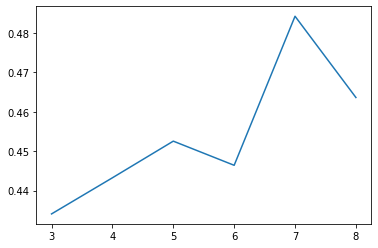

In [ ]:
plt.plot(topic_num, coherence)

In [ ]:
opt_num = 7
lda_model = gensim.models.LdaModel(corpus = bow_corpus,
                                        id2word = dictionary,
                                        num_topics = opt_num,
                                        offset = 2,
                                        random_state = 123,
                                        update_every = 1,
                                        passes = 10,
                                        alpha = 'auto',
                                        eta = "auto",
                                        per_word_topics = True)

In [ ]:
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.034*"effect" + 0.032*"side" + 0.031*"feel" + 0.021*"day" + 0.021*"week" + '
  '0.017*"take" + 0.016*"start" + 0.016*"like" + 0.012*"first" + 0.011*"get"'),
 (1,
  '0.029*"took" + 0.027*"day" + 0.018*"hour" + 0.018*"pill" + 0.016*"take" + '
  '0.015*"work" + 0.013*"time" + 0.012*"go" + 0.010*"start" + 0.010*"water"'),
 (2,
  '0.031*"cramp" + 0.028*"period" + 0.022*"pain" + 0.020*"get" + 0.019*"month" '
  '+ 0.019*"day" + 0.019*"bleed" + 0.016*"got" + 0.012*"week" + '
  '0.012*"insert"'),
 (3,
  '0.018*"patch" + 0.018*"inject" + 0.017*"use" + 0.011*"drug" + 0.010*"insur" '
  '+ 0.009*"effect" + 0.008*"one" + 0.008*"tri" + 0.007*"cover" + '
  '0.007*"doctor"'),
 (4,
  '0.044*"weight" + 0.033*"month" + 0.028*"gain" + 0.018*"year" + 0.018*"pill" '
  '+ 0.015*"control" + 0.015*"pound" + 0.014*"start" + 0.013*"lost" + '
  '0.012*"lb"'),
 (5,
  '0.017*"year" + 0.017*"take" + 0.016*"anxieti" + 0.015*"life" + '
  '0.014*"medic" + 0.011*"work" + 0.011*"drug" + 0.011*"feel" + '
  '0.011*

In [ ]:
# Compute Perplexity (lower is better)
print('Perplexity: ', lda_model.log_perplexity(bow_corpus))  

# Compute Coherence Score (higher is better)
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Perplexity:  -6.841213835996103

Coherence Score:  0.48422873078162026


## Visualizations

### pyLDAvis

In [ ]:
%%capture
!pip install pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.002651  0.070626       1        1  21.998426
0      0.073855  0.017734       2        1  16.838859
2      0.077168 -0.121573       3        1  15.836609
6     -0.003445  0.164314       4        1  15.708036
4      0.096677 -0.157960       5        1  13.944602
1      0.057433  0.090129       6        1  10.709820
3     -0.299038 -0.063269       7        1   4.963648, topic_info=         Term          Freq         Total Category  logprob  loglift
87     weight   8889.000000   8889.000000  Default  30.0000  30.0000
318      pain  12687.000000  12687.000000  Default  29.0000  29.0000
1766    cramp   7244.000000   7244.000000  Default  28.0000  28.0000
958   migrain   7192.000000   7192.000000  Default  27.0000  27.0000
59       gain   5769.000000   5769.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
333     howev    306.923835   2252.528197   Topic7  -5.4650   1.0098
117      side    345.568565  10482.862564   Topic7  -5.3465  -0.4093
134       bad    327.190668   6736.952088   Topic7  -5.4011  -0.0218
151     would    329.646277   9459.969688   Topic7  -5.3936  -0.3538
218     thing    304.082698   4882.761067   Topic7  -5.4743   0.2269

[513 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
1287       1  1.000057       abilifi
3620       6  0.998666         abort
3490       6  0.998292          achi
4447       5  0.999808           acn
539        1  0.104969        actual
...      ...       ...           ...
89         7  0.005120          year
14500      5  1.000986  zolmitriptan
255        1  0.998957        zoloft
3641       4  0.999770         zomig
4043       5  0.999862       zyprexa

[1082 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 3, 7, 5, 2, 4])

### t-SNE

In [ ]:
# https://stackoverflow.com/questions/60454355/draw-3d-plot-for-gensim-model
def LDA_tSNE_topics_vis(dimension='both',
                        corpus=None, 
                        num_topics=10,
                        remove_3d_outliers=False,
                        save_png=False):
    """
    Returns the outputs of an LDA model plotted using t-SNE (t-distributed Stochastic Neighbor Embedding)

    Note: t-SNE reduces the dimensionality of a space such that similar points will be closer and dissimilar points farther

    Parameters
    ----------
        dimension : str (default=both)
            The dimension that t-SNE should reduce the data to for visualization
            Options: 2d, 3d, and both (a plot with two subplots)

        corpus : list, list of lists
            The tokenized and cleaned text corpus over which analysis should be done

        num_topics : int (default=10)
            The number of categories for LDA based approaches

        remove_3d_outliers : bool (default=False)
            Whether to remove outliers from a 3d plot

        save_png : bool (default=False)
            Whether to save the figure as a png

    Returns
    -------
        A t-SNE lower dimensional representation of an LDA model's topics and their constituent members
    """
    # dirichlet_dict = corpora.Dictionary(reviews)
    # bow_corpus = [dirichlet_dict.doc2bow(text) for text in reviews]
    # dirichlet_model = LdaModel(corpus=bow_corpus,
    #                            id2word=dirichlet_dict,
    #                            num_topics=num_topics,
    #                            update_every=1,
    #                            chunksize=len(bow_corpus),
    #                            passes=10,
    #                            alpha='auto',
    #                            eta = 'auto',
    #                            random_state=123,
    #                            offset = 2,
    #                            per_word_topics = True)

    dirichlet_dict = dictionary
    dirichlet_model = lda_model

    df_topic_coherences = pd.DataFrame(columns = ['topic_{}'.format(i) for i in range(num_topics)])

    for i in range(len(bow_corpus)):
        df_topic_coherences.loc[i] = [0] * num_topics
        
        output = dirichlet_model.__getitem__(bow=bow_corpus[i], eps=0)
    
        for j in range(num_topics):
            _, coherence = output[0][j]
            df_topic_coherences.iloc[i, j] = coherence

    for i in range(num_topics):
        df_topic_coherences.iloc[:, i] = df_topic_coherences.iloc[:, i].astype('float64', copy=False)

    df_topic_coherences['main_topic'] = df_topic_coherences.iloc[:, :num_topics].idxmax(axis=1)

    if num_topics > 10:
        # cubehelix better for more than 10 colors
        colors = sns.color_palette("cubehelix", num_topics)
    else:
        # The default sns color palette
        colors = sns.color_palette('deep', num_topics)

    tsne_2 = None
    tsne_3 = None
    if dimension == 'both':
        tsne_2 = TSNE(n_components=2, perplexity=40, n_iter=300)
        tsne_3 = TSNE(n_components=3, perplexity=40, n_iter=300)
    elif dimension == '2d':
        tsne_2 = TSNE(n_components=2, perplexity=40, n_iter=300)
    elif dimension == '3d':
        tsne_3 = TSNE(n_components=3, perplexity=40, n_iter=300)
    else:
        ValueError("An invalid value has been passed to the 'dimension' argument - choose from 2d, 3d, or both.")

    if tsne_2 is not None:
        tsne_results_2 = tsne_2.fit_transform(df_topic_coherences.iloc[:, :num_topics])
        
        df_tsne_2 = pd.DataFrame()
        df_tsne_2['tsne-2d-d1'] = tsne_results_2[:,0]
        df_tsne_2['tsne-2d-d2'] = tsne_results_2[:,1]
        df_tsne_2['main_topic'] = df_topic_coherences.iloc[:, num_topics]
        df_tsne_2['color'] = [colors[int(t.split('_')[1])] for t in df_tsne_2['main_topic']]

        df_tsne_2['topic_num'] = [int(i.split('_')[1]) for i in df_tsne_2['main_topic']]
        df_tsne_2 = df_tsne_2.sort_values(['topic_num'], ascending = True).drop('topic_num', axis=1)
    
    if tsne_3 is not None:
        colors = [c for c in sns.color_palette()]

        tsne_results_3 = tsne_3.fit_transform(df_topic_coherences.iloc[:, :num_topics])
        
        df_tsne_3 = pd.DataFrame()
        df_tsne_3['tsne-3d-d1'] = tsne_results_3[:,0]
        df_tsne_3['tsne-3d-d2'] = tsne_results_3[:,1]
        df_tsne_3['tsne-3d-d3'] = tsne_results_3[:,2]
        df_tsne_3['main_topic'] = df_topic_coherences.iloc[:, num_topics]
        df_tsne_3['color'] = [colors[int(t.split('_')[1])] for t in df_tsne_3['main_topic']]

        df_tsne_3['topic_num'] = [int(i.split('_')[1]) for i in df_tsne_3['main_topic']]
        df_tsne_3 = df_tsne_3.sort_values(['topic_num'], ascending = True).drop('topic_num', axis=1)

        if remove_3d_outliers:
            # Remove those rows with values that are more than three standard deviations from the column mean
            for col in ['tsne-3d-d1', 'tsne-3d-d2', 'tsne-3d-d3']:
                df_tsne_3 = df_tsne_3[np.abs(df_tsne_3[col] - df_tsne_3[col].mean()) <= (3 * df_tsne_3[col].std())]

    if tsne_2 is not None and tsne_3 is not None:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, # pylint: disable=unused-variable
                                       figsize=(20,10))
        ax1.axis('off')

    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))

    if tsne_2 is not None and tsne_3 is not None:
        # Plot tsne_2, with tsne_3 being added later
        ax1 = sns.scatterplot(data=df_tsne_2, x="tsne-2d-d1", y="tsne-2d-d2",
                              hue=df_topic_coherences.iloc[:, num_topics], alpha=0.3)
        
        light_grey_tup = (242/256, 242/256, 242/256)
        ax1.set_facecolor(light_grey_tup)
        ax1.axes.set_title('t-SNE 2-Dimensional Representation', fontsize=25)
        ax1.set_xlabel('tsne-d1', fontsize=20)
        ax1.set_ylabel('tsne-d2', fontsize=20)

        handles, labels = ax1.get_legend_handles_labels()
        legend_order = list(np.argsort([i.split('_')[1] for i in labels]))
        ax1.legend([handles[i] for i in legend_order], [labels[i] for i in legend_order], 
                   facecolor=light_grey_tup)

    elif tsne_2 is not None:
        # Plot just tsne_2
        ax = sns.scatterplot(data=df_tsne_2, x="tsne-2d-d1", y="tsne-2d-d2",
                             hue=df_topic_coherences.iloc[:, num_topics], alpha=0.3)

        ax.set_facecolor(light_grey_tup)
        ax.axes.set_title('t-SNE 2-Dimensional Representation', fontsize=25)
        ax.set_xlabel('tsne-d1', fontsize=20)
        ax.set_ylabel('tsne-d2', fontsize=20)

        handles, labels = ax.get_legend_handles_labels()
        legend_order = list(np.argsort([i.split('_')[1] for i in labels]))
        ax.legend([handles[i] for i in legend_order], [labels[i] for i in legend_order], 
                  facecolor=light_grey_tup)

    if tsne_2 is not None and tsne_3 is not None:
        # tsne_2 has been plotted, so add tsne_3
        ax2 = fig.add_subplot(121, projection='3d')
        ax2.scatter(xs=df_tsne_3['tsne-3d-d1'], 
                    ys=df_tsne_3['tsne-3d-d2'], 
                    zs=df_tsne_3['tsne-3d-d3'],  
                    c=df_tsne_3['color'],
                    alpha=0.3)

        ax2.set_facecolor('white')
        ax2.axes.set_title('t-SNE 3-Dimensional Representation', fontsize=25)
        ax2.set_xlabel('tsne-d1', fontsize=20)
        ax2.set_ylabel('tsne-d2', fontsize=20)
        ax2.set_zlabel('tsne-d3', fontsize=20)

        with plt.rc_context({"lines.markeredgewidth" : 0}):
            # Add handles via blank lines and order their colors to match tsne_2
            proxy_handles = [Line2D([0], [0], linestyle="none", marker='o', markersize=8,
                                    markerfacecolor=colors[i]) for i in legend_order]
            ax2.legend(proxy_handles, ['topic_{}'.format(i) for i in range(num_topics)], 
                       loc='upper left', facecolor=(light_grey_tup))

    elif tsne_3 is not None:
        # Plot just tsne_3
        ax.axis('off')
        ax.set_facecolor('white')
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(xs=df_tsne_3['tsne-3d-d1'], 
                   ys=df_tsne_3['tsne-3d-d2'], 
                   zs=df_tsne_3['tsne-3d-d3'],  
                   c=df_tsne_3['color'],
                   alpha=0.3)

        ax.set_facecolor('white')
        ax.axes.set_title('t-SNE 3-Dimensional Representation', fontsize=25)
        ax.set_xlabel('tsne-d1', fontsize=20)
        ax.set_ylabel('tsne-d2', fontsize=20)
        ax.set_zlabel('tsne-d3', fontsize=20)

        with plt.rc_context({"lines.markeredgewidth" : 0}):
            # Add handles via blank lines
            proxy_handles = [Line2D([0], [0], linestyle="none", marker='o', markersize=8,
                                    markerfacecolor=colors[i]) for i in range(len(colors))]
            ax.legend(proxy_handles, ['topic_{}'.format(i) for i in range(num_topics)], 
                      loc='upper left', facecolor=light_grey_tup)

    if save_png:
        plt.savefig('LDA_tSNE_{}.png'.format(time.strftime("%Y%m%d-%H%M%S")), bbox_inches='tight', dpi=500)

    plt.show()

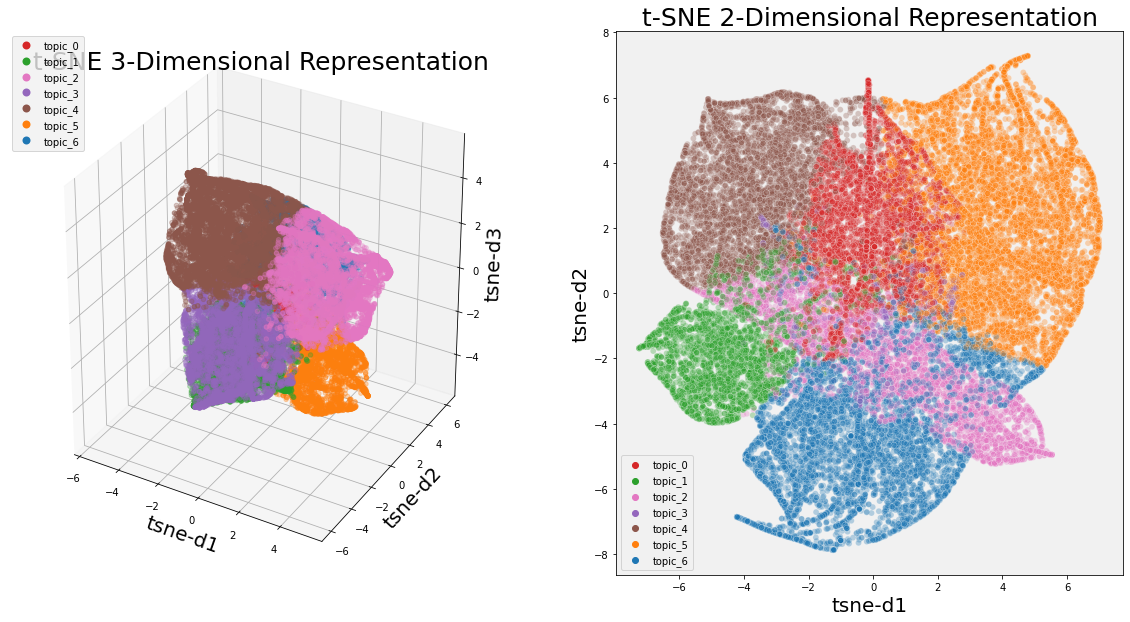

In [ ]:
LDA_tSNE_topics_vis(dimension='both',
                        corpus=None, 
                        num_topics=7,
                        remove_3d_outliers=False,
                        save_png=False)

### Topic - reviews relationships

In [ ]:
# Find information abou topic and documents (just the first)
all_topics = lda_model.get_document_topics(bow_corpus, per_word_topics=True)

for doc_topics, word_topics, phi_values in all_topics:
    print('New Document \n')
    print('Document topics:', doc_topics)
    print('Word topics:', word_topics)
    print('Phi values:', phi_values)
    print(" ")
    print('-------------- \n')
    break

New Document 

Document topics: [(0, 0.014819886), (3, 0.03380533), (5, 0.36920792), (6, 0.574327)]
Word topics: [(0, [5, 6]), (1, [5, 6, 3]), (2, [5]), (3, [5, 6, 0]), (4, [6, 5, 3]), (5, [6]), (6, [6, 5]), (7, [6, 5, 0]), (8, [6, 5]), (9, [6, 5, 3]), (10, [6, 5]), (11, [6, 0]), (12, [5, 6, 3]), (13, [5, 6, 3]), (14, [6, 5, 0, 3]), (15, [6, 5]), (16, [6, 5]), (17, [6, 5]), (18, [6, 5, 0]), (19, [6, 5, 0]), (20, [6]), (21, [5, 6, 3]), (22, [6]), (23, [5, 6, 3]), (24, [6, 5, 0]), (25, [6, 5, 3, 0]), (26, [6, 5, 3]), (27, [6, 5]), (28, [6, 0]), (29, [6]), (30, [6, 5, 3]), (31, [6, 5]), (32, [6, 5, 3]), (33, [5]), (34, [5, 6]), (35, [6, 5]), (36, [6]), (37, [6, 5]), (38, [5, 6, 3]), (39, [6, 5, 0]), (40, [5, 3]), (41, [6, 5]), (42, [6, 5]), (43, [5, 6, 3]), (44, [6]), (45, [6, 5, 3]), (46, [5, 6, 0]), (47, [3, 0])]
Phi values: [(0, [(5, 0.6050675), (6, 0.39493248)]), (1, [(3, 0.036888022), (5, 0.51447755), (6, 0.44840184)]), (2, [(5, 0.99999994)]), (3, [(0, 0.027680734), (5, 0.60634243), 

In [ ]:
def find_topic(row, which = 0):
  idx = row['index']
  coherences = lda_model.__getitem__(bow=bow_corpus[idx], eps=0)[0]
  coherences = sorted(coherences, key = lambda x: x[1], reverse = True)
  return coherences[which][0]

In [ ]:
# See the most relevant topic for each review
data['index'] = [i for i in range(data.shape[0])]
data['top_topic'] = data.apply(lambda x: find_topic(x, which = 0), axis = 1)
data.head()

,drugName,condition,review,rating,date,positiveness,drugClass,index,top_topic
0,trazodone,Insomnia,"""I have insomnia, it's horrible. My story begi...",10.0,"April 3, 2016",1,antidepressants,0,6
1,fluvoxamine,Anxiety and Stress,"""I've suffered from panic attacks and anxiety ...",9.0,"January 3, 2011",1,antidepressants,1,5
2,mirtazapine,Anxiety,"""Suffered from anxiety and depression for 3 mo...",10.0,"May 31, 2012",1,antidepressants,2,5
3,trazodone,Depression,"""I take trazodone to help balance the effects ...",10.0,"June 1, 2016",1,antidepressants,3,6
4,mirtazapine,Anxiety,"""I have taken this medicine for 7 years. Gaine...",10.0,"November 6, 2012",1,antidepressants,4,6


In [125]:
# Just a checkpoint
# data = pd.read_csv('data.csv')

In [126]:
def conf_int_prop(row, conf, which):
  n = row['n']
  p = row['count']/n
  z = - scipy.stats.norm.ppf((1-conf)/2, 0, 1)
  lower = round(p - z*np.sqrt((p*(1-p))/n), 3)
  upper = round(p + z*np.sqrt((p*(1-p))/n), 3)
  if which == 'lower': return lower
  else: return upper

In [127]:
conf = .999 # must be: 0 < conf < 1

In [128]:
# Create confidence intervals for proportion (topic prevalence in positive ratings)
results = data.groupby(['top_topic', 'positiveness'], as_index = False).count()[['top_topic', 'positiveness', 'index']].rename({'index':'count', 'top_topic' : 'topic'}, axis = 1)
n = results.groupby(['topic'], as_index = False).sum()[['topic', 'count']].rename({'count':'n'}, axis = 1)
results = pd.merge(results, n, how = 'left', on = ['topic'])
results['p'] = results.apply(lambda x: round(x['count']/x['n'], 3), axis =1)
results['lower'] = results.apply(lambda x: conf_int_prop(x, conf, 'lower'), axis = 1)
results['upper'] = results.apply(lambda x: conf_int_prop(x, conf, 'upper'), axis = 1)

# Filter positive topics
results = results[results['positiveness'] == 1]

# Rename topics
results['topic'] = results['topic'].apply(lambda x: x+1)

results.head()

([], [])

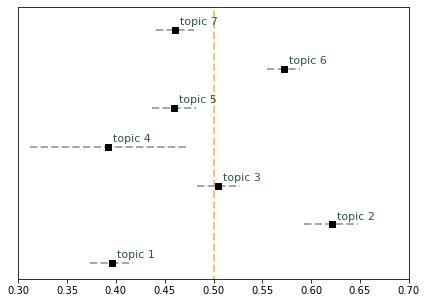

In [130]:
# Plot
plt.figure(figsize = (7, 5))
plt.scatter('p', 'topic', data = results,
         color = 'black', s = 35, marker = 's', zorder = 1)
plt.hlines('topic', 'lower', 'upper', data = results,
           colors='#a8a8a8', linestyles = 'dashed', linewidth = 2, zorder = 0)
plt.vlines(0.5, -1, 8,
           colors='#ff9900', linestyles = 'dashed', linewidth = 2, zorder = -1, alpha = 0.6)

# annotate
annotation = results.copy()
annotation['topic_string'] = annotation['topic'].apply(lambda x: f'topic {x}')
annotation = pd.DataFrame(annotation.set_index('topic_string')[['p','topic']])
for k, v in annotation.iterrows():
    plt.annotate(k, v,
                 xytext=(5,5), textcoords='offset points',
                 family='sans-serif', fontsize=11, color='darkslategrey')
plt.xlim((0.3, 0.7))
plt.ylim((0.6, 7.6))
plt.yticks([])

In [131]:
# Create confidence intervals for proportion (topic prevalence in positive rating for each drugClass)
results = data.groupby(['top_topic', 'positiveness', 'drugClass'], as_index = False).count()[['top_topic','drugClass', 'positiveness', 'index']].rename({'index':'count', 'top_topic' : 'topic'}, axis = 1)
n = results.groupby(['topic', 'drugClass'], as_index = False).sum()[['topic', 'drugClass','count']].rename({'count':'n'}, axis = 1)
results = pd.merge(results, n, how = 'left', on = ['topic', 'drugClass'])
results['p'] = results.apply(lambda x: round(x['count']/x['n'], 3), axis =1)
results['lower'] = results.apply(lambda x: conf_int_prop(x, conf, 'lower'), axis = 1)
results['upper'] = results.apply(lambda x: conf_int_prop(x, conf, 'upper'), axis = 1)

# Filter positive topics
results = results[results['positiveness'] == 1]

# Rename topics
results['topic'] = results['topic'].apply(lambda x: x+1)

results.head()

,topic,drugClass,positiveness,count,n,p,lower,upper
14,1,anorexiants,1,245,570,0.430,0.362,0.498
15,1,antidepressants,1,916,2133,0.429,0.394,0.465
16,1,antimigraine-agents,1,5,32,0.156,-0.055,0.367
17,1,atypical-antipsychotics,1,138,371,0.372,0.289,0.455
18,1,cns-stimulants,1,70,195,0.359,0.246,0.472


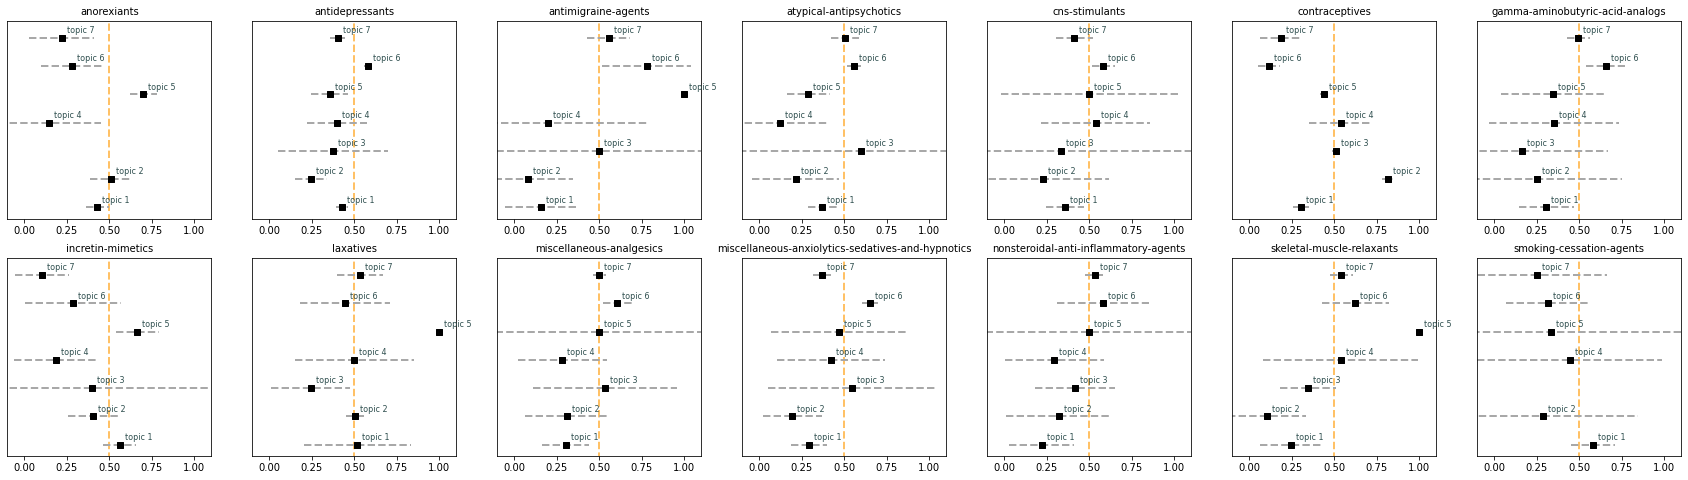

In [138]:
# Plots
fig, axs = plt.subplots(2, 7, figsize = (30, 8))
i, j = 0, 0
for c in np.unique(results['drugClass']):
  df = results[results['drugClass'] == c]
  axs[i, j].scatter('p', 'topic', data = df,
         color = 'black', s = 35, marker = 's', zorder = 1)
  axs[i, j].hlines('topic', 'lower', 'upper', data = df,
           colors='#a8a8a8', linestyles = 'dashed', linewidth = 2, zorder = 0)
  axs[i, j].vlines(0.5, -1, 8,
           colors='#ff9900', linestyles = 'dashed', linewidth = 2, zorder = -1, alpha = 0.6)
  axs[i, j].set_title(f"{c}", fontsize = 10)
  axs[i, j].set_xlim((-0.1, 1.1))
  axs[i, j].set_ylim((0.6, 7.6))
  axs[i, j].set_yticks([])

  # annotation
  annotation = df.copy()
  annotation['topic_string'] = annotation['topic'].apply(lambda x: f'topic {x}')
  annotation = pd.DataFrame(annotation.set_index('topic_string')[['p','topic']])
  for k, v in annotation.iterrows():
      axs[i, j].annotate(k, v,
                  xytext=(5,5), textcoords='offset points',
                  family='sans-serif', fontsize=8, color='darkslategrey')
    
  j += 1
  if j == 7:
    i, j = 1, 0